<a href="https://colab.research.google.com/github/Ugo5738/synthetic-data/blob/main/Synthetic_Data_Utility_and_Privacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Run the code:

- The code is designed to run from top to bottom.

## Make imports 

In [ ]:
!pip install diffprivlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV

# models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb

# privacy
from statistics import mean
from diffprivlib import tools as dp

import warnings
warnings.filterwarnings('ignore')

## Explore Datasets

In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/public_health_ori.csv")
df2 = pd.read_csv("/content/drive/MyDrive/public_health_syn_1.csv")
df3 = pd.read_csv("/content/drive/MyDrive/public_health_syn_2.csv")

### Dataset 1

In [ ]:
df1.head()

,Unnamed: 0,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [ ]:
df1.describe()

,Unnamed: 0,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,21699.500000,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,12528.645178,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,0.000000,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,10849.750000,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,21699.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,32549.250000,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,43399.000000,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


View columns with null values

In [ ]:
df1.isnull().sum()

Unnamed: 0               0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

- We can fill the bmi column using its mean
- We can fill the smoking_status column using:
  - the age column
  - an Xgboost model

**Columns with categorical values**

These feature columns have to be transformed to numerical columns

In [ ]:
df1.gender.value_counts()

Female    25665
Male      17724
Other        11
Name: gender, dtype: int64

In [ ]:
df1.ever_married.value_counts()

Yes    27938
No     15462
Name: ever_married, dtype: int64

In [ ]:
df1.work_type.value_counts()

Private          24834
Self-employed     6793
children          6156
Govt_job          5440
Never_worked       177
Name: work_type, dtype: int64

In [ ]:
df1.Residence_type.value_counts()

Urban    21756
Rural    21644
Name: Residence_type, dtype: int64

In [ ]:
df1.smoking_status.value_counts()

never smoked       16053
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64

View target feature balance

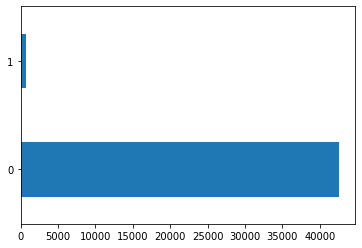

In [ ]:
df1['stroke'].value_counts().plot(kind='barh')

The target column has to be upsampled to balance the data.

### Dataset 2

In [ ]:
df2.head()

,Unnamed: 0,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Female,46.558918,0,0,Yes,Private,Urban,61.469372,31.584820,NaN,0
1,1,Male,72.260345,0,0,Yes,Private,Rural,88.089638,25.384787,never smoked,0
2,2,Male,15.017832,0,0,No,children,Rural,178.221603,30.279047,never smoked,0
3,3,Female,19.782211,0,0,No,Private,Rural,216.142349,29.158499,never smoked,0
4,4,Male,52.642868,0,0,Yes,Private,Urban,178.901016,37.867107,never smoked,0


In [ ]:
df2.describe()

,Unnamed: 0,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.000000,43395.000000,43400.000000,43400.000000,43396.000000,42883.000000,43400.000000
mean,21699.500000,42.522152,0.088571,0.045668,102.143888,29.002074,0.017696
std,12528.645178,21.370482,0.284127,0.208767,38.423407,7.563389,0.131845
min,0.000000,1.865363,0.000000,0.000000,38.899124,9.566272,0.000000
25%,10849.750000,25.906280,0.000000,0.000000,77.230145,23.873502,0.000000
50%,21699.500000,44.070492,0.000000,0.000000,90.824245,28.175097,0.000000
75%,32549.250000,59.408981,0.000000,0.000000,110.518177,33.175072,0.000000
max,43399.000000,96.005936,1.000000,1.000000,328.130249,74.360596,1.000000


View columns with null values

In [ ]:
df2.isnull().sum()

Unnamed: 0               0
gender                   0
age                      5
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        4
bmi                    517
smoking_status       13174
stroke                   0
dtype: int64

- We can fill the age, bmi and avg_glucose_level column using their corresponding mean
- We can fill the smoking_status column using:
  - the age column
  - an Xgboost model

**Columns with categorical values**

These feature columns have to be transformed to numerical columns

In [ ]:
df2.gender.value_counts()

Female    26100
Male      17272
Other        28
Name: gender, dtype: int64

In [ ]:
df2.ever_married.value_counts()

Yes    27999
No     15401
Name: ever_married, dtype: int64

In [ ]:
df2.work_type.value_counts()

Private          25273
Self-employed     6999
children          5896
Govt_job          5041
Never_worked       191
Name: work_type, dtype: int64

In [ ]:
df2.Residence_type.value_counts()

Urban    21844
Rural    21556
Name: Residence_type, dtype: int64

In [ ]:
df2.smoking_status.value_counts()

never smoked       16286
formerly smoked     7252
smokes              6688
Name: smoking_status, dtype: int64

View target feature balance

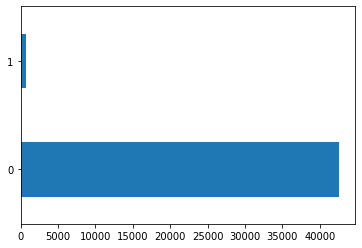

In [ ]:
df2['stroke'].value_counts().plot(kind='barh')

### Dataset 3

In [ ]:
df3.head()

,Unnamed: 0,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,39.230114,0,0,No,Private,Urban,81.494720,22.602545,smokes,0
1,1,Female,46.884335,0,0,No,Self-employed,Rural,133.478119,40.833950,never smoked,0
2,2,Female,58.254971,1,0,Yes,Self-employed,Urban,123.809082,33.464554,never smoked,0
3,3,Male,8.297491,0,0,No,children,Rural,102.157021,23.413242,NaN,0
4,4,Male,23.581894,0,0,No,Private,Urban,82.137550,22.303869,NaN,0


In [ ]:
df3.describe()

,Unnamed: 0,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.000000,43390.000000,43400.000000,43400.000000,43396.000000,42671.000000,43400.000000
mean,21699.500000,41.131919,0.063203,0.027097,103.082300,29.059823,0.019147
std,12528.645178,21.480514,0.243330,0.162367,36.765133,7.924456,0.137045
min,0.000000,3.231856,0.000000,0.000000,31.510170,11.012136,0.000000
25%,10849.750000,24.473059,0.000000,0.000000,79.004898,23.681385,0.000000
50%,21699.500000,42.494968,0.000000,0.000000,93.291176,28.064131,0.000000
75%,32549.250000,57.881371,0.000000,0.000000,113.887991,33.272034,0.000000
max,43399.000000,92.229919,1.000000,1.000000,336.990601,78.784599,1.000000


View columns with null values

In [ ]:
df3.isnull().sum()

Unnamed: 0               0
gender                   0
age                     10
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        4
bmi                    729
smoking_status       13140
stroke                   0
dtype: int64

- We can fill the age, bmi and avg_glucose_level column using their corresponding mean
- We can fill the smoking_status column using:
  - the age column
  - an Xgboost model

**Columns with categorical values**

These feature columns have to be transformed to numerical columns

In [ ]:
df3.gender.value_counts()

Female    25939
Male      17459
Other         2
Name: gender, dtype: int64

In [ ]:
df3.ever_married.value_counts()

Yes    27671
No     15729
Name: ever_married, dtype: int64

In [ ]:
df3.work_type.value_counts()

Private          29275
children          7246
Govt_job          3398
Self-employed     3368
Never_worked       113
Name: work_type, dtype: int64

In [ ]:
df3.Residence_type.value_counts()

Urban    21902
Rural    21498
Name: Residence_type, dtype: int64

In [ ]:
df3.smoking_status.value_counts()

never smoked       16624
formerly smoked     7138
smokes              6498
Name: smoking_status, dtype: int64

View target feature balance

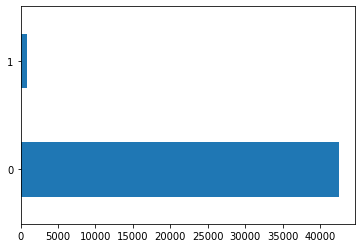

In [ ]:
df3['stroke'].value_counts().plot(kind='barh')

## Utility functions and classes

### EDA

Load and read dataset using Pandas

In [ ]:
def load_data(data_path):
    df = pd.read_csv(data_path)
    return df

Fill NaN values in a feature column using its average.

In [ ]:
def fill_nan_with_mean(df, feature):
    # fill NaN values
    mean_value = df[feature].mean()
    df[feature].fillna(value=mean_value, inplace=True)

**Wrangle Data**
- Fill feature columns with its corresponding mean
- Fill smoking status of individuals less than 15 years old as "never smoked". It is safe to assume that to a large extent, children would not have smoked before.
- Divide the Dataframe into two using the 'smoking_status' feature column:
  - Dataframe of NaN values (dataframe A)
  - Dataframe of the remaider observations (dataframe B)

Note: 

- we are spliting the data into two to build a model that can predict on the 'smoking_status' NaN values (dataframe A) using information learnt from the existing values in (dataframe B)

In [ ]:
def wrangle_data(df, nan_features=None):

    if nan_features:
        if "age" in nan_features:
            fill_nan_with_mean(df, "age")

        if "avg_glucose_level" in nan_features:
            fill_nan_with_mean(df, "avg_glucose_level")

        if "bmi" in nan_features:
            fill_nan_with_mean(df, "bmi") 

    # fill smoking status for young adults as never smoked
    young_adult_df = df.loc[(df['age'] < 15)]
    young_adult_nan_list = young_adult_df[young_adult_df['smoking_status'].isnull()].index.tolist()
    df.at[young_adult_nan_list, 'smoking_status'] = 'never smoked'

    # get all nan indexes
    nan_index = df[df['smoking_status'].isnull()].index.tolist()  

    # Seperate nan indexes from original data
    df_index = [i for i in range(len(df))]
    df_rem_index = list(set(df_index) - set(nan_index))
    df_nan = df.iloc[nan_index,:]
    df_rem = df.iloc[df_rem_index,:]
    
    return df, df_nan, df_rem

Define our Xs (independent variable) and ys (dependent variable) from the dataframe.

In [ ]:
def get_features_target(df, column_list):
    X = df.drop(column_list, axis=1)
    y_col = column_list[-1]
    y = df[y_col]
    return X, y

**Preprocess Data:**

- Use a labelEncoder class to assign integer values to features with categorical values.
- Drop columns that are not needed
- Generate additional features and transform the X feature vector using the PolynomialFeatures api from sklearn

In [ ]:
def preprocessing_data(df, preprocess_columns, drop_columns, encode_y, scale_feature=False):
    label_encoder = LabelEncoder()

    for column in preprocess_columns:
        df.loc[:, column] = label_encoder.fit_transform(df[column])
    
    X, y = get_features_target(df, drop_columns)

    if scale_feature:
        polynomial_builder = PolynomialFeatures(degree=2, include_bias=False)
        X = polynomial_builder.fit_transform(X)

    if encode_y:
        y = label_encoder.fit_transform(y)

    return X, y

The dataset is heavily imbalanced so we would apply upsampling to balance the dataset where necessary

In [ ]:
def balance_data(X, y):
    sm = SMOTE(sampling_strategy='minority', random_state=42)
    oversampled_X, oversampled_Y = sm.fit_resample(X, y)
    
    return oversampled_X, oversampled_Y

### Training

Train the defined model using preprocessed data

In [ ]:
def train_data(X, y, classifier, classifier_name, show_performance):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score    
    
    performance = {}

    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        random_state=46, 
                                                        train_size=.75, 
                                                        stratify=y)
    
    clf = classifier
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy_score = accuracy_score(y_test, y_pred)
    precision_score = precision_score(y_test, y_pred, average='micro')
    recall_score = recall_score(y_test, y_pred, average='micro')
    f1_score = f1_score(y_test, y_pred, average='micro')

    if show_performance:
        performance["Accuracy"] = accuracy_score
        performance["Precision"] = precision_score
        performance["Recall"] = recall_score
        performance["F1 score"] = f1_score
        return clf, y_pred, performance

    return clf, y_pred, accuracy_score

### Manage Operation

Create a manager class that handles end-to-end training of a single dataset.

In [ ]:
class Manager:
    def __init__(self, data_path, nan_features):
        self.df = load_data(data_path)
        self.nan_features = nan_features
    
    def load_data(self):
        self.df, self.df_nan, self.df_rem = wrangle_data(self.df, self.nan_features)
        return self.df, self.df_nan, self.df_rem

    def prepare_data(self, df, 
                     preprocess_columns, 
                     drop_columns, 
                     scale_feature=True, 
                     bal_data=True, 
                     encode_y=True): 
        X, y = preprocessing_data(df, 
                                  preprocess_columns, 
                                  drop_columns, 
                                  encode_y, 
                                  scale_feature)
        if bal_data:
            X, y = balance_data(X, y)
        return X, y

    def train_data(self, X, y, classifier, classifier_name, show_performance=True):
        classifier, pred, scores = train_data(X, y, classifier, classifier_name, show_performance)
        return classifier, pred, scores

## Implementation

Handle all dataset at once and store the results

In [ ]:
nan_feature_col = ["age", "bmi", "avg_glucose_level"]

data_paths = {
    "/content/drive/MyDrive/public_health_ori.csv": nan_feature_col[1],
    "/content/drive/MyDrive/public_health_syn_1.csv": nan_feature_col,
    "/content/drive/MyDrive/public_health_syn_2.csv": nan_feature_col
    }

# columns to preprocess
INITIAL_PREPROCESS_COLUMNS = ["gender", "ever_married", "work_type", "Residence_type"]
INITIAL_DROP_COLUMNS = ['Unnamed: 0', 'smoking_status']

SECOND_PREPROCESS_COLUMNS = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
SECOND_DROP_COLUMNS = ['Unnamed: 0']

FINAL_PREPROCESS_COLUMNS = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
FINAL_DROP_COLUMNS = ['stroke']

performance_dict = {}
data_privacy = {}

for i, data_path in enumerate(data_paths.items()):
    print(f"Dataset {i}")

    data_manager = Manager(data_path[0], data_path[1])
    df, df_nan, df_rem = data_manager.load_data()

    #====================== FILL UP NAN VALUES IN DATASET ======================
    # Train XGBoost model using the dataset that has no NaN values
    # XGBoost model seems to be the best performing model for this task

    DF = data_manager.df_rem

    # Preprocess df using the INITIAL_PREPROCESS_COLUMNS and 
    # INITIAL_DROP_COLUMNS
    X, y = data_manager.prepare_data(df=DF, 
                                     preprocess_columns=INITIAL_PREPROCESS_COLUMNS, 
                                     drop_columns=INITIAL_DROP_COLUMNS)
    
    CLASSIFIER=xgb.XGBClassifier()
    CLASSIFIER_NAME="Xgboost"
    classifier, pred, score = data_manager.train_data(X, y,
                                                      classifier=CLASSIFIER, 
                                                      classifier_name=CLASSIFIER_NAME,
                                                      show_performance=False)


    # Predict NaN values in the 'smoking_status' feature column using 
    # trained XGBoost model

    DF = data_manager.df_nan
    BAL_DATA = False
    ENCODE_Y = False

    X_nan, _ = data_manager.prepare_data(df=DF,
                                         preprocess_columns=INITIAL_PREPROCESS_COLUMNS, 
                                         drop_columns=INITIAL_DROP_COLUMNS,
                                         bal_data=BAL_DATA,
                                         encode_y=ENCODE_Y)
    y_nan_pred = classifier.predict(X_nan)
    nan_index_list = DF.index.tolist()

    # Input the predicted values for NaNs into the main dataframe to create
    # a new dataframe with no NaN values
    DF = data_manager.df
    SCALE_FEATURE = False
    BAL_DATA = False
    ENCODE_Y = False

    new_df, _ = data_manager.prepare_data(df=DF,
                                          preprocess_columns=SECOND_PREPROCESS_COLUMNS, 
                                          drop_columns=SECOND_DROP_COLUMNS,
                                          scale_feature=SCALE_FEATURE,
                                          bal_data=BAL_DATA,
                                          encode_y=ENCODE_Y)

    new_df.at[nan_index_list, 'smoking_status'] = y_nan_pred 

    #===================== BUILD MODEL USING THE MAIN DATA =====================
    # Random Forest Classifier model seems to be the best performing model 
    # for this task

    DF = new_df
    SCALE_FEATURE = False
    BAL_DATA = True
    ENCODE_Y = False

    X, y = data_manager.prepare_data(df=DF,
                                     preprocess_columns=FINAL_PREPROCESS_COLUMNS, 
                                     drop_columns=FINAL_DROP_COLUMNS,
                                     scale_feature=SCALE_FEATURE,
                                     bal_data=BAL_DATA,
                                     encode_y=ENCODE_Y)
    
    CLASSIFIER = RandomForestClassifier()
    CLASSIFIER_NAME = "Random Forest"

    classifier, y_pred, performance = data_manager.train_data(X, y,
                                                              classifier=CLASSIFIER, 
                                                              classifier_name=CLASSIFIER_NAME)

    performance_dict[f"Dataset {i}"] = performance

    #================================= PRIVACY =================================
    error_avg = []
    privacy_data = {}
    
    # Values are between 0 & 1
    col1 = ["hypertension", "heart_disease", "ever_married", "Residence_type", "stroke"]
    # Values are between 1 & 2
    col2 = ["gender", "smoking_status"]
    
    for ind, column in enumerate(new_df.columns):
        # We know from the dataset that everyone in the dataset is at least 1 
        # years of age. As of 2019, less than 0.005% of the world's population 
        # is aged over 100, so this is an appropriate simplification. Values 
        # in the dataset above 100 will be excluded from calculations.
        range_ = (1, 100)
        if column in col1:
            range_ = (0, 1)
        elif column in col2:
            range_ = (0, 2)
        # Values are between 1 & 2
        elif column == "work_type":
            range_ = (0, 4) 
        # A normal blood glucose level for adults, without diabetes, who haven’t 
        # eaten for at least eight hours (fasting) is less than 100 mg/dL. A 
        # normal blood glucose level for adults, without diabetes, two hours 
        # after eating, is 90 to 110 mg/dL.
        elif column == "avg_glucose_level":
            range_ = (80, 110) 
        # Values are between 10 & 30
        # The ideal bmi for adults is 18.5 to 24.9
        # The ideal bmi for children is 2 to 18        
        elif column == "bmi":
            range_ = (2, 25)                         
        
        column_data = new_df.iloc[:, ind].values

        # Using Numpy's native histogram function, we can get the distribution 
        # of the feature column.
        hist, bins = np.histogram(column_data)
        hist = hist / hist.sum()

        # dp_hist, dp_bins = dp.histogram(column_data)
        # dp_hist = dp_hist / dp_hist.sum()
        # error = np.abs(hist - dp_hist).sum()

        # Using diffprivlib, we can calculate a differentially private version 
        # of the histogram.
        dp_hist, dp_bins = dp.histogram(column_data, epsilon=0.1, range=range_)
        dp_hist = dp_hist / dp_hist.sum()

        # Total histogram error
        error = np.abs(hist - dp_hist).sum()
        error_avg.append(error)

    # Calculate the average error of all columns in a dataset
    avg_mean_error = mean(error_avg)
    data_privacy[f"Dataset {i}"] = avg_mean_error

Dataset 0
Dataset 1
Dataset 2


## Metrics

### Utility

In [ ]:
for metric, result in performance_dict.items():
    print(f"{metric}: {result}")

Dataset 0: {'Accuracy': 0.9730630250129053, 'Precision': 0.9730630250129053, 'Recall': 0.9730630250129053, 'F1 score': 0.9730630250129053}
Dataset 1: {'Accuracy': 0.9674422968662038, 'Precision': 0.9674422968662038, 'Recall': 0.9674422968662038, 'F1 score': 0.9674422968662038}
Dataset 2: {'Accuracy': 0.9659854357528777, 'Precision': 0.9659854357528777, 'Recall': 0.9659854357528777, 'F1 score': 0.9659854357528778}


**My thought:**

- I built and trained a model on the original dataset to get a baseline accuracy score.

- Test that model on the synthetic datasets; the extent to which the result deviates from the original shows how much similar the datasets are.

- This inturn shows how much utility the synthetic dataset has in comparison to its parent dataset (original dataset).

**Deduction**

With the above logic:

- The more similar synthetic dataset to the original dataset is:
public_health_syn_1.csv

### Privacy

In [ ]:
for i, data in data_privacy.items():
    print(f"{i}: {data}")

Dataset 0 0.35997563667963617
Dataset 1 0.29559558988630064
Dataset 2 0.3227503324671602


**My thought:**

- Using diffprivlib, we can calculate how much privacy is in a column using specific parameters:
  - epsilon: how much noise is introduced into the dataset.
  - range: the upper and lower bounds on which to focus the privacy calculation.

- The mean error shows the average error in the dataset, in orderwords, it shows how private the data in the dataset is.

**Deduction**

With the above logic:

- Using the original dataset's privacy as the baseline, the synthetic dataset with the farthest value from the baseline value would be the most private dataset.
  - the most private dataset would be: public_health_syn_1.csv

### Suggestion:

- public_health_syn_1.csv would be the best dataset to use in place of the original because it has the highest utility and the most private.